# Binning(Discretisasasi) Menggunakan K-Mean kLastering

Binning (Discretization) adalah proses mengubah fitur numerik kontinu menjadi fitur kategorikal atau ordinal. Misalnya, nilai umur bisa dikelompokkan menjadi "Muda", "Dewasa", dan "Lansia". Tujuannya adalah untuk:

* Mengurangi kompleksitas data.

* Menangani outlier.

* Memenuhi prasyarat model tertentu (misalnya Naive Bayes).

* Memberikan interpretasi yang lebih mudah.

Mengapa Gunakan K-Means?

Metode klasik seperti equal-width atau equal-frequency tidak memperhitungkan sebaran data. K-Means Clustering lebih adaptif karena membentuk cluster berdasarkan pola alami distribusi data.



## Instalasi library yang dibutuhkan

In [99]:
!pip install pymysql
!pip install psycopg2-binary
!pip install pandas tabulate
!pip install scikit-fuzzy


## Visualisasi data Iris dengan menyisahkan kolom sepal Length

In [100]:
import pymysql
import pandas as pd
from tabulate import tabulate

# Konfigurasi koneksi ke database MySQL
DB_HOST = "mysql-pendata23-175-mysqlpendata23-175.g.aivencloud.com"
DB_PORT = 17974
DB_NAME = "defaultdb"
DB_USER = "avnadmin"
DB_PASS = "AVNS_756YWhIqpe1WzSKsGNx"

try:
    # Membuat koneksi ke MySQL
    conn = pymysql.connect(
        host=DB_HOST,
        port=DB_PORT,
        user=DB_USER,
        password=DB_PASS,
        database=DB_NAME,
        cursorclass=pymysql.cursors.DictCursor  # Mengembalikan hasil sebagai dictionary
    )
    cur = conn.cursor()

    # Menjalankan query SQL
    query = "SELECT * FROM irisno.Iris ORDER BY id ASC;"  # Sesuaikan dengan nama tabel
    cur.execute(query)
    rows = cur.fetchall()

    # Jika tabel kosong
    if not rows:
        print("Tabel kosong, tidak ada data untuk ditampilkan.")
    else:
        # Mengubah hasil query menjadi DataFrame pandas
        df = pd.DataFrame(rows)

        # Memastikan kolom 'id' dan 'sepal_length' ada sebelum memproses
        required_columns = ['Id', 'sepal length']
        if all(col in df.columns for col in required_columns):
            # Menyimpan hanya kolom 'id' dan 'sepal_length'
            df = df[required_columns]
        else:
            print(f"Salah satu atau lebih kolom yang diperlukan ({', '.join(required_columns)}) tidak ditemukan dalam tabel.")
            # Buat DataFrame kosong dengan kolom yang dibutuhkan jika tidak ditemukan
            df = pd.DataFrame(columns=required_columns)

        # Menampilkan 3 data awal, titik-titik di tengah, dan 3 data akhir
        if not df.empty:
            df_selected = pd.concat([df.head(3), pd.DataFrame([["..."] * len(df.columns)], columns=df.columns), df.tail(3)])
            # Menampilkan tabel dengan format psql
            print(tabulate(df_selected, headers="keys", tablefmt="psql", showindex=False))
        else:
            print("Tidak ada data untuk ditampilkan setelah filter kolom.")

except Exception as e:
    print("Error:", e)

finally:
    # Menutup koneksi ke database
    if cur:
        cur.close()
    if conn:
        conn.close()

+------+----------------+
| Id   | sepal length   |
|------+----------------|
| 1    | 5.1            |
| 2    | 4.9            |
| 3    | 4.7            |
| ...  | ...            |
| 148  | 6.5            |
| 149  | 6.2            |
| 150  | 5.9            |
+------+----------------+


## Melakukan Klastering dengan menggunakan K-Means klastering

K-Means adalah Teknik pengelompokan (clustering) berbasis partisi membagi data menjadi K kelompok berdasarkan jarak setiap kelompok direpresentasikan oleh centroid(rata-rata jarak dari titik dalam kluster) atau biasa disebut titik pusat suatu klaster.

Data yang sering kali tidak memiliki label-->Unsupervised learning clustering membantu mengelompokkan data berdasarkan kesamaan karakteristik


### tujuan dan fungsi klustering

### Tujuan dan Fungsi Klaster (Clustering)

**Clustering** adalah salah satu teknik utama dalam **unsupervised learning** yang bertujuan untuk mengelompokkan data berdasarkan kemiripan atau kedekatan karakteristik tanpa menggunakan label atau target output. Klastering sering digunakan dalam data mining, analisis data eksploratif, segmentasi pasar, dan banyak bidang lain.

---

#### 🎯 **Tujuan Klastering**

1. **Mengelompokkan Data Serupa**
   Tujuan utama klastering adalah mengelompokkan data ke dalam beberapa **kelompok (klaster)** sedemikian rupa sehingga:

   * Data dalam satu klaster **mirip** satu sama lain (intra-cluster similarity tinggi).
   * Data antar klaster **berbeda jauh** (inter-cluster dissimilarity tinggi).

2. **Reduksi Kompleksitas Data**
   Dengan membagi data ke dalam klaster, kita bisa menyederhanakan analisis data, terutama saat bekerja dengan data besar dan kompleks.

3. **Mengidentifikasi Pola atau Struktur Tersembunyi**
   Klastering dapat membantu mengungkap pola tersembunyi dalam data yang mungkin tidak tampak secara langsung.

4. **Segmentasi**
   Dalam dunia bisnis dan pemasaran, klastering digunakan untuk membagi pelanggan ke dalam segmen berdasarkan perilaku atau atribut tertentu (misalnya: segmentasi pelanggan, segmentasi wilayah, dll).

---

### 🛠️ **Fungsi Klastering dalam Analisis Data**

| Fungsi                           | Penjelasan                                                                                          |
| -------------------------------- | --------------------------------------------------------------------------------------------------- |
| **Eksplorasi Data**              | Klaster membantu memahami struktur data, mendeteksi outlier, dan mengidentifikasi grup penting.     |
| **Pra-pemrosesan**               | Dapat digunakan sebelum algoritma supervised learning untuk menyaring atau mengelompokkan data.     |
| **Rekomendasi Sistem**           | Sistem rekomendasi sering menggunakan klastering untuk menemukan grup pengguna dengan minat serupa. |
| **Pengelompokan Dokumen / Teks** | Untuk mengelompokkan artikel, berita, atau dokumen berdasarkan topik utama.                         |
| **Deteksi Anomali**              | Data yang tidak masuk ke klaster manapun bisa dianggap sebagai anomali atau outlier.                |
| **Biologi / Genetika**           | Untuk mengelompokkan gen, ekspresi gen, atau jenis sel berdasarkan karakteristik biologis.          |





### Langkah Langkah Algoritma K-Means

1. Tentukan jumlah cluster
Disini saya akan mencoba dengan data yang ditampilkan membaginya dengan 2,3,4 klaster
2. Pilih K centroid awal secara acak setiap klaster memiliki 1 centroid
3. Hitung jarak setiap data ke tiap centroid
gunakan rumus Encludian Distance
$$
d(\mathbf{x}, \mathbf{c}) = \sqrt{ \sum_{i=1}^{n} (x_i - c_i)^2 }
$$


### Penjelasan:

* $\mathbf{x} = (x_1, x_2, \ldots, x_n)$: vektor data.
* $\mathbf{c} = (c_1, c_2, \ldots, c_n)$: vektor centroid.
* $n$: jumlah dimensi atau fitur.
* $d(\mathbf{x}, \mathbf{c})$: jarak Euclidean antara data dan centroid.

4. Kelompokan data dengan centroid terdekat
5. Hitung ulang centroid dari rata rata anggota kluster
$$
\mu_k = \frac{1}{N_k} \sum_{x_i \in C_k} x_i
$$
### ✅ Penjelasan:

* **\$\mu\_k\$**
  Menyatakan **centroid (titik pusat)** dari klaster ke-**\$k\$**.

* **\$N\_k\$**
  Jumlah **data (anggota)** yang terdapat dalam klaster ke-**\$k\$**.

* **\$x\_i \in C\_k\$**
  Menyatakan bahwa **\$x\_i\$** adalah titik data yang termasuk ke dalam klaster **\$C\_k\$**.

* **\$\sum\_{x\_i \in C\_k} x\_i\$**
  Menyatakan jumlah (penjumlahan vektor) dari seluruh titik data yang berada di dalam klaster **\$C\_k\$**.

* **\$\frac{1}{N\_k}\$**
  Digunakan untuk menghitung rata-rata dari semua anggota dalam klaster tersebut.

6. Ulangi langkah 3-5 hingga konvergen(tidak ada perubahan signifikan)



Pada Kolom sepal Length ini dibagi kedalam 4 klaster yaitu A,B,C,D

Data hasil klaster disimpan dalam variabel 'df_raw_from_db' dengan label A-D.


<ipython-input-101-1129553682>:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', n_clusters)


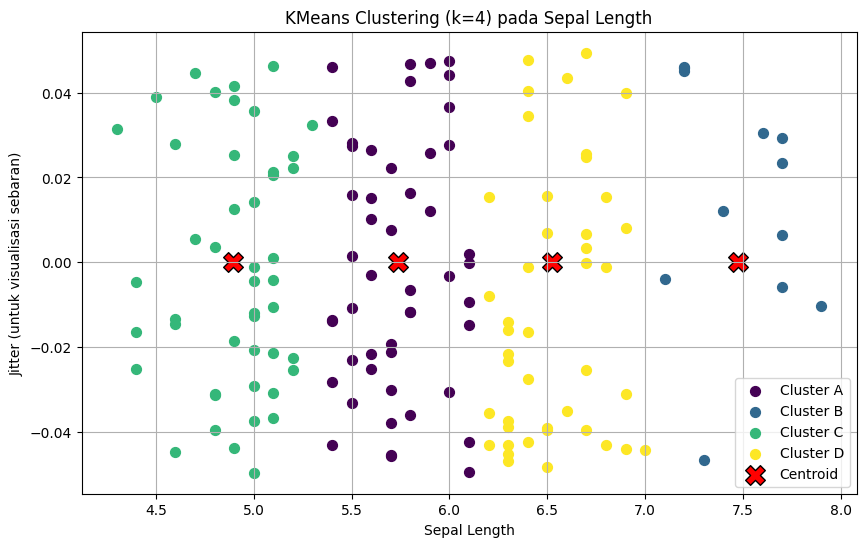


Nilai Centroid untuk setiap klaster:
Cluster A: 4.8957
Cluster B: 5.7347
Cluster C: 6.5256
Cluster D: 7.4750

Id dan Data Klaster Sepal Length:
+------+----------------+
|   Id | Sepal Length   |
|------+----------------|
|    1 | C              |
|    2 | C              |
|    3 | C              |
|    4 | C              |
|    5 | C              |
|    6 | A              |
|    7 | C              |
|    8 | C              |
|    9 | C              |
|   10 | C              |
|   11 | A              |
|   12 | C              |
|   13 | C              |
|   14 | C              |
|   15 | A              |
|   16 | A              |
|   17 | A              |
|   18 | C              |
|   19 | A              |
|   20 | C              |
|   21 | A              |
|   22 | C              |
|   23 | C              |
|   24 | C              |
|   25 | C              |
|   26 | C              |
|   27 | C              |
|   28 | C              |
|   29 | C              |
|   30 | C             

In [101]:
import pymysql
import pandas as pd
import numpy as np
from tabulate import tabulate # Import tabulate untuk menampilkan tabel
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt # Diperlukan untuk plt.show(), plt.scatter, dll.

# --- Konfigurasi Koneksi ke Database MySQL ---
DB_HOST = "mysql-pendata23-175-mysqlpendata23-175.g.aivencloud.com"
DB_PORT = 17974
DB_NAME = "defaultdb"
DB_USER = "avnadmin"
DB_PASS = "AVNS_756YWhIqpe1WzSKsGNx"

try:
    # Membuat koneksi ke MySQL
    conn = pymysql.connect(
        host=DB_HOST,
        port=DB_PORT,
        user=DB_USER,
        password=DB_PASS,
        database=DB_NAME,
        cursorclass=pymysql.cursors.DictCursor # Mengembalikan hasil sebagai dictionary
    )
    cur = conn.cursor()

    # Menjalankan query SQL untuk mengambil semua kolom (`SELECT *`)
    query = "SELECT * FROM irisno.Iris ORDER BY id ASC;"
    cur.execute(query)
    rows = cur.fetchall()

    if not rows:
        print("Tabel kosong, tidak ada data untuk diproses.")
    else:
        # Mengubah hasil query menjadi DataFrame pandas
        # df_raw_from_db akan mempertahankan nama kolom asli dari database (misal: 'sepal length')
        df_raw_from_db = pd.DataFrame(rows)

        # Buat salinan DataFrame untuk proses klastering dan pengubahan nama kolom agar lebih mudah diakses di Python
        df_for_clustering = df_raw_from_db.copy()
        # Mengubah 'sepal length' menjadi 'sepal_length' di df_for_clustering untuk kemudahan akses Python
        if 'sepal length' in df_for_clustering.columns:
            df_for_clustering.rename(columns={'sepal length': 'sepal_length'}, inplace=True)

        # Ambil fitur numerik untuk klastering: hanya 'sepal_length' dari df_for_clustering
        val_X = df_for_clustering[['sepal_length']].values

        # --- KMeans Model untuk 4 Klaster ---
        n_clusters = 4 # Menentukan jumlah klaster
        k_means_model = KMeans(
            n_clusters=n_clusters,
            init='k-means++', # Metode inisialisasi centroid
            n_init=10,        # Jumlah kali algoritma K-Means dijalankan
            max_iter=400,
            tol=0.0001,
            random_state=42,  # Untuk hasil yang reproducible
            algorithm='lloyd' # Algoritma K-Means yang digunakan
        )

        # Latih model K-Means
        k_means_model.fit(val_X)

        # Ambil label klaster untuk setiap data point
        cluster_labels_numeric = k_means_model.labels_ # Simpan label numerik asli
        # Ambil koordinat centroid dari setiap klaster
        cluster_centroids = k_means_model.cluster_centers_

        # --- Konversi Label Klaster Numerik ke Huruf (A, B, C, D) ---
        label_mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
        cluster_labels_alpha = np.array([label_mapping[label] for label in cluster_labels_numeric])

        # --- Ganti nama kolom 'id' menjadi 'Id' di DataFrame asli (df_raw_from_db) ---
        if 'id' in df_raw_from_db.columns:
            df_raw_from_db.rename(columns={'id': 'Id'}, inplace=True)

        # --- Ganti kolom 'sepal length' dengan hasil klaster dan ubah namanya ---
        if 'sepal length' in df_raw_from_db.columns:
            df_raw_from_db['sepal length'] = cluster_labels_alpha # Timpa kolom asli dengan label klaster
            # Ubah nama kolomnya menjadi 'Sepal Length Klaster' untuk kejelasan
            df_raw_from_db.rename(columns={'sepal length': 'Sepal Length'}, inplace=True)

        print("Data hasil klaster disimpan dalam variabel 'df_raw_from_db' dengan label A-D.")

        # --- Visualisasi Hasil Klaster ---
        plt.figure(figsize=(10, 6))
        colors = plt.cm.get_cmap('viridis', n_clusters)

        for i in range(n_clusters):
            y_jitter = np.random.rand(val_X[cluster_labels_numeric == i].shape[0]) * 0.1 - 0.05
            plt.scatter(
                val_X[cluster_labels_numeric == i, 0],  # Sumbu X adalah 'sepal_length' (dari df_for_clustering)
                y_jitter,                              # Sumbu Y adalah nilai jitter
                s=50,
                color=colors(i),
                label=f'Cluster {label_mapping[i]}' # Gunakan label huruf pada legenda
            )

        # Plot centroid
        plt.scatter(
            cluster_centroids[:, 0], # Sumbu X adalah posisi centroid
            np.zeros(cluster_centroids.shape[0]), # Sumbu Y centroid berada di 0 (tanpa jitter)
            s=200,
            c='red',
            edgecolor='black',
            marker='X',
            label='Centroid'
        )

        plt.title(f'KMeans Clustering (k={n_clusters}) pada Sepal Length')
        plt.xlabel('Sepal Length')
        plt.ylabel('Jitter (untuk visualisasi sebaran)') # Label sumbu Y yang menjelaskan jitter
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- Tampilkan Nilai Centroid ---
        print("\nNilai Centroid untuk setiap klaster:")
        sorted_indices = np.argsort(cluster_centroids.flatten())
        for i, idx in enumerate(sorted_indices):
            print(f"Cluster {label_mapping[i]}: {cluster_centroids[idx][0]:.4f}")

        # --- Tampilkan Id dan Kolom Klaster 'Sepal Length Klaster' ---
        print("\nId dan Data Klaster Sepal Length:")
        print(tabulate(df_raw_from_db[['Id', 'Sepal Length']], headers='keys', tablefmt='psql', showindex=False))

except Exception as e:
    print(f"Terjadi Error: {e}")

finally:
    # Menutup koneksi ke database
    if 'cur' in locals() and cur:
        cur.close()
    if 'conn' in locals() and conn:
        conn.close()


## Menggabungkan data yang sudah di klastering menggunakan K-Means pada kolom Sepal Length dengan kolom yang di drop tadi mengembalikan nilai Sepal Length berupa kategorical

In [102]:
import pymysql
import pandas as pd
import numpy as np
from tabulate import tabulate # Import tabulate untuk menampilkan tabel
from sklearn.cluster import KMeans

# --- Konfigurasi Koneksi ke Database MySQL ---
DB_HOST = "mysql-pendata23-175-mysqlpendata23-175.g.aivencloud.com"
DB_PORT = 17974
DB_NAME = "defaultdb"
DB_USER = "avnadmin"
DB_PASS = "AVNS_756YWhIqpe1WzSKsGNx"

df_original_full = pd.DataFrame() # Inisialisasi DataFrame kosong

try:
    # Membuat koneksi ke MySQL
    conn = pymysql.connect(
        host=DB_HOST,
        port=DB_PORT,
        user=DB_USER,
        password=DB_PASS,
        database=DB_NAME,
        cursorclass=pymysql.cursors.DictCursor # Mengembalikan hasil sebagai dictionary
    )
    cur = conn.cursor()

    # Menjalankan query SQL untuk mengambil semua kolom yang relevan
    # Pastikan nama kolom sesuai dengan yang ada di database Anda
    # Jika ada spasi di nama kolom, gunakan backticks (` `)
    query = "SELECT id, `sepal length`, `sepal width`, `petal length`, `petal width` FROM irisno.Iris ORDER BY id ASC;"
    cur.execute(query)
    rows = cur.fetchall()

    if not rows:
        print("Tabel kosong, tidak ada data untuk diproses.")
    else:
        # Mengubah hasil query menjadi DataFrame pandas
        df_original_full = pd.DataFrame(rows)

        # Pastikan nama kolom diubah menjadi format tanpa spasi agar mudah diakses di Python
        if 'sepal length' in df_original_full.columns:
            df_original_full.rename(columns={'sepal length': 'sepal_length'}, inplace=True)
        if 'sepal width' in df_original_full.columns:
            df_original_full.rename(columns={'sepal width': 'sepal_width'}, inplace=True)
        if 'petal length' in df_original_full.columns:
            df_original_full.rename(columns={'petal length': 'petal_length'}, inplace=True)
        if 'petal width' in df_original_full.columns:
            df_original_full.rename(columns={'petal width': 'petal_width'}, inplace=True)

        # Ambil fitur numerik untuk klastering: hanya 'sepal_length'
        val_X = df_original_full[['sepal_length']].values

        # --- KMeans Model untuk 4 Klaster ---
        n_clusters = 4
        k_means_model = KMeans(
            n_clusters=n_clusters,
            init='k-means++',
            n_init=10,
            max_iter=400,
            tol=0.0001,
            random_state=42,
            algorithm='lloyd'
        )

        # Latih model K-Means
        k_means_model.fit(val_X)

        # Ambil label klaster numerik
        cluster_labels_numeric = k_means_model.labels_

        # --- Konversi Label Klaster Numerik ke Huruf (A, B, C, D) ---
        label_mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
        cluster_labels_alpha = np.array([label_mapping[label] for label in cluster_labels_numeric])

        # --- Gabungkan Data Cluster dengan Fitur Lainnya ---
        df_final_dataset = df_original_full.copy()

        # Hapus kolom 'sepal_length' yang asli
        df_final_dataset = df_final_dataset.drop(columns=['sepal_length'])

        # Tambahkan kolom klaster baru sebagai pengganti 'sepal_length'
        df_final_dataset['sepal_length_cluster'] = cluster_labels_alpha

        # --- Tampilkan DataFrame Hasil Akhir ---
        print("Berikut adalah DataFrame final Anda dengan kolom klaster sebagai pengganti 'sepal_length':")
        print(tabulate(df_final_dataset, headers='keys', tablefmt='psql', showindex=False))

except Exception as e:
    print(f"Terjadi Error: {e}")

finally:
    # Menutup koneksi ke database
    if 'cur' in locals() and cur:
        cur.close()
    if 'conn' in locals() and conn:
        conn.close()


Berikut adalah DataFrame final Anda dengan kolom klaster sebagai pengganti 'sepal_length':
+------+---------------+----------------+---------------+------------------------+
|   id |   sepal_width |   petal_length |   petal_width | sepal_length_cluster   |
|------+---------------+----------------+---------------+------------------------|
|    1 |           3.5 |            1.4 |           0.2 | C                      |
|    2 |           3   |            1.4 |           0.2 | C                      |
|    3 |           3.2 |            1.3 |           0.2 | C                      |
|    4 |           3.1 |            1.5 |           0.2 | C                      |
|    5 |           3.6 |            1.4 |           0.2 | C                      |
|    6 |           3.9 |            1.7 |           0.4 | A                      |
|    7 |           3.4 |            1.4 |           0.3 | C                      |
|    8 |           3.4 |            1.5 |           0.2 | C                    

## Melakukan klastering pada semua fitur menggunakan K-Means dengan 4 Klaster untuk fitur Sepal Length dan Petal Length dan 3 klaster untuk Sepal Width dan Petal Width

In [103]:
import pymysql
import pandas as pd
import numpy as np
from tabulate import tabulate # Import tabulate untuk menampilkan tabel
from sklearn.cluster import KMeans

# --- Konfigurasi Koneksi ke Database MySQL ---
DB_HOST = "mysql-pendata23-175-mysqlpendata23-175.g.aivencloud.com"
DB_PORT = 17974
DB_NAME = "defaultdb"
DB_USER = "avnadmin"
DB_PASS = "AVNS_756YWhIqpe1WzSKsGNx"

df_original_full = pd.DataFrame() # Inisialisasi DataFrame kosong

try:
    # Membuat koneksi ke MySQL
    conn = pymysql.connect(
        host=DB_HOST,
        port=DB_PORT,
        user=DB_USER,
        password=DB_PASS,
        database=DB_NAME,
        cursorclass=pymysql.cursors.DictCursor # Mengembalikan hasil sebagai dictionary
    )
    cur = conn.cursor()

    # Menjalankan query SQL untuk mengambil semua kolom (`SELECT *`)
    query = "SELECT * FROM irisno.Iris ORDER BY Id ASC;"
    cur.execute(query)
    rows = cur.fetchall()

    if not rows:
        print("Tabel kosong, tidak ada data untuk diproses.")
    else:
        # Mengubah hasil query menjadi DataFrame pandas
        df_original_full = pd.DataFrame(rows)

        # Pastikan nama kolom diubah menjadi format tanpa spasi agar mudah diakses di Python
        # Kolom-kolom ini akan digunakan untuk klastering atau disimpan kembali
        if 'sepal length' in df_original_full.columns:
            df_original_full.rename(columns={'sepal length': 'sepal length'}, inplace=True)
        if 'sepal width' in df_original_full.columns:
            df_original_full.rename(columns={'sepal width': 'sepal width'}, inplace=True)
        if 'petal length' in df_original_full.columns:
            df_original_full.rename(columns={'petal length': 'petal length'}, inplace=True)
        if 'petal width' in df_original_full.columns:
            df_original_full.rename(columns={'petal width': 'petal width'}, inplace=True)
        # Jika ada kolom 'Class' dari SELECT *, kita akan tetap menanganinya

        # --- Fungsi Pembantu untuk Klastering dan Penamaan ---
        def apply_kmeans_and_map_labels(df, column_name, n_clusters, label_start_char='A'):
            """
            Melakukan K-Means clustering pada kolom tertentu dan
            mengkonversi label numerik menjadi huruf.
            """
            val_X = df[[column_name]].values
            k_means_model = KMeans(
                n_clusters=n_clusters,
                init='k-means++',
                n_init=10,
                max_iter=400,
                tol=0.0001,
                random_state=42,
                algorithm='lloyd'
            )
            k_means_model.fit(val_X)
            cluster_labels_numeric = k_means_model.labels_

            # Buat mapping dari angka ke huruf (misal: 0->A, 1->B, dst.)
            label_mapping = {i: chr(ord(label_start_char) + i) for i in range(n_clusters)}
            cluster_labels_alpha = np.array([label_mapping[label] for label in cluster_labels_numeric])

            return cluster_labels_alpha

        # --- 2. Aplikasikan K-Means dan Konversi Label untuk Setiap Fitur ---

        # Klastering 'sepal_length' dengan 4 klaster (A-D)
        df_original_full['sepal length'] = apply_kmeans_and_map_labels(
            df_original_full, 'sepal length', 4, 'A'
        )

        # Klastering 'petal_length' dengan 4 klaster (A-D)
        df_original_full['petal length'] = apply_kmeans_and_map_labels(
            df_original_full, 'petal length', 4, 'A'
        )

        # Klastering 'sepal_width' dengan 3 klaster (A-C)
        df_original_full['sepal width'] = apply_kmeans_and_map_labels(
            df_original_full, 'sepal width', 3, 'A'
        )

        # Klastering 'petal_width' dengan 3 klaster (A-C)
        df_original_full['petal width'] = apply_kmeans_and_map_labels(
            df_original_full, 'petal width', 3, 'A'
        )

        # --- 3. Siapkan DataFrame Final ---
        # Buat DataFrame baru dengan 'id', 'Class' (jika ada), dan kolom-kolom klaster baru
        columns_to_include = ['Id']
        if 'Class' in df_original_full.columns: # Cek apakah kolom 'Class' ada
            columns_to_include.append('Class')

        columns_to_include.extend([
            'sepal length',
            'sepal width',
            'petal length',
            'petal width'
        ])

        df_final_dataset = df_original_full[columns_to_include].copy()


        # --- 4. Tampilkan DataFrame Hasil Akhir ---
        # Menampilkan seluruh DataFrame menggunakan tabulate
        print("Berikut adalah DataFrame final Anda dengan kolom klaster sebagai pengganti fitur numerik asli:")
        print(tabulate(df_final_dataset, headers='keys', tablefmt='psql', showindex=False))

except Exception as e:
    print(f"Terjadi Error: {e}")

finally:
    # Menutup koneksi ke database
    if 'cur' in locals() and cur:
        cur.close()
    if 'conn' in locals() and conn:
        conn.close()


Berikut adalah DataFrame final Anda dengan kolom klaster sebagai pengganti fitur numerik asli:
+------+-----------------+----------------+---------------+----------------+---------------+
|   Id | Class           | sepal length   | sepal width   | petal length   | petal width   |
|------+-----------------+----------------+---------------+----------------+---------------|
|    1 | Iris-setosa     | C              | B             | B              | B             |
|    2 | Iris-setosa     | C              | A             | B              | B             |
|    3 | Iris-setosa     | C              | A             | B              | B             |
|    4 | Iris-setosa     | C              | A             | B              | B             |
|    5 | Iris-setosa     | C              | B             | B              | B             |
|    6 | Iris-setosa     | A              | B             | B              | B             |
|    7 | Iris-setosa     | C              | B             | B       

### 🌼 Klasifikasi Naive Bayes untuk Data Kategorikal

**Naive Bayes** adalah sebuah algoritma klasifikasi yang efisien dan didasarkan pada **Teorema Bayes**. Algoritma ini disebut "naive" (lugu) karena mengasumsikan bahwa setiap fitur (variabel prediktor) bersifat **independen** atau tidak saling memengaruhi satu sama lain dalam menentukan kelas.

Untuk kasus di mana data Anda sepenuhnya bersifat kategorikal, varian yang paling sesuai untuk digunakan adalah `CategoricalNB`, yang tersedia dalam pustaka (library) machine learning seperti `scikit-learn`.

---

### 📘 Teorema Bayes

Fondasi dari algoritma ini adalah Teorema Bayes, yang secara matematis dirumuskan sebagai berikut:

$$P(C|X) = \frac{P(X|C) \cdot P(C)}{P(X)}$$

Dimana:

* **$P(C|X)$ (Probabilitas Posterior)**: Ini adalah probabilitas dari suatu kelas **$C$** (misalnya, 'Iris-setosa'), dengan diketahui adanya data observasi **$X$**. Inilah nilai yang ingin kita maksimalkan untuk menentukan kelas dari data baru.

* **$P(X|C)$ (Likelihood)**: Probabilitas munculnya data observasi **$X$** dengan syarat data tersebut merupakan bagian dari kelas **$C$**. Dalam Naive Bayes, karena asumsi independensi, nilai ini dihitung sebagai perkalian probabilitas dari setiap fitur:
    $$P(X|C) = P(x_1|C) \cdot P(x_2|C) \cdot \ldots \cdot P(x_n|C)$$

* **$P(C)$ (Probabilitas Prior)**: Probabilitas awal (sebelum melihat data) dari sebuah kelas **$C$**. Biasanya dihitung berdasarkan frekuensi kemunculan setiap kelas pada data pelatihan. Misalnya, jika dari 100 data, 40 di antaranya adalah kelas 'A', maka $P(A) = 0.4$.

* **$P(X)$ (Evidence)**: Probabilitas dari data observasi **$X$**. Dalam konteks klasifikasi, nilai ini bertindak sebagai faktor normalisasi dan nilainya akan sama untuk semua kelas. Oleh karena itu, perhitungan $P(X)$ seringkali **diabaikan** karena tidak memengaruhi perbandingan nilai probabilitas posterior antar kelas.

### Inisialisa Library

In [104]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


### Inisialisasi data fitur kategorical

In [105]:
# df_final_dataset = hasil dari proses clustering Anda
# Kolom: Id, Class, sepal length, sepal width, petal length, petal width
print(df_final_dataset.head(150))


      Id           Class sepal length sepal width petal length petal width
0      1     Iris-setosa            C           B            B           B
1      2     Iris-setosa            C           A            B           B
2      3     Iris-setosa            C           A            B           B
3      4     Iris-setosa            C           A            B           B
4      5     Iris-setosa            C           B            B           B
..   ...             ...          ...         ...          ...         ...
145  146  Iris-virginica            D           A            A           A
146  147  Iris-virginica            D           C            A           A
147  148  Iris-virginica            D           A            A           A
148  149  Iris-virginica            D           B            D           A
149  150  Iris-virginica            A           A            A           A

[150 rows x 6 columns]


### ubah data Huruf menjadi angka 0-3 untuk 4 klaster dan 0-2 untuk 3 klaster

In [106]:
# Memisahkan Fitur X Dan Y yang merupakan Target
X = df_final_dataset[['sepal length', 'sepal width', 'petal length', 'petal width']]
y = df_final_dataset['Class']
# Ubah Fitur Kategorikal ke Numerik (OrdinalEncoder)
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)


# Konversi ke DataFrame agar bisa dilihat dengan nama kolom
df_encoded = pd.DataFrame(X_encoded, columns=X.columns)

# Tampilkan 10 data teratas
print("Data setelah di-encode (ordinal):")
print(df_encoded.head(150))

Data setelah di-encode (ordinal):
     sepal length  sepal width  petal length  petal width
0             2.0          1.0           1.0          1.0
1             2.0          0.0           1.0          1.0
2             2.0          0.0           1.0          1.0
3             2.0          0.0           1.0          1.0
4             2.0          1.0           1.0          1.0
..            ...          ...           ...          ...
145           3.0          0.0           0.0          0.0
146           3.0          2.0           0.0          0.0
147           3.0          0.0           0.0          0.0
148           3.0          1.0           3.0          0.0
149           0.0          0.0           0.0          0.0

[150 rows x 4 columns]


### Latih data dan Prediksi menggunakan Naive Bayes

In [118]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tabulate import tabulate

# --- Siapkan Data ---
X = df_final_dataset[['sepal length', 'sepal width', 'petal length', 'petal width']]
y = df_final_dataset['Class']

# --- Encoding kategori fitur ---
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

# --- Encoding label kelas menjadi angka ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.3, random_state=42
)

# --- Latih model ---
model = CategoricalNB()
model.fit(X_train, y_train)

# --- Prediksi seluruh data ---
y_pred_all = model.predict(X_encoded)

# --- Tambahkan hasil prediksi numerik ke DataFrame ---
df_final_dataset_with_pred = df_final_dataset.copy()
df_final_dataset_with_pred['Prediksi'] = y_pred_all  # Sudah berupa angka 0, 1, 2

# --- Tampilkan seluruh data ---
print("=== Seluruh Data Iris dengan Hasil Klasifikasi Naive Bayes (dalam angka) ===")
print(tabulate(df_final_dataset_with_pred, headers='keys', tablefmt='psql', showindex=False))


=== Seluruh Data Iris dengan Hasil Klasifikasi Naive Bayes (dalam angka) ===
+------+-----------------+----------------+---------------+----------------+---------------+------------+
|   Id | Class           | sepal length   | sepal width   | petal length   | petal width   |   Prediksi |
|------+-----------------+----------------+---------------+----------------+---------------+------------|
|    1 | Iris-setosa     | C              | B             | B              | B             |          0 |
|    2 | Iris-setosa     | C              | A             | B              | B             |          0 |
|    3 | Iris-setosa     | C              | A             | B              | B             |          0 |
|    4 | Iris-setosa     | C              | A             | B              | B             |          0 |
|    5 | Iris-setosa     | C              | B             | B              | B             |          0 |
|    6 | Iris-setosa     | A              | B             | B              

### Hitung Akurasinya

`accuracy_score(y_true, y_pred)` menghitung akurasi, yang didefinisikan sebagai:

$$
\text{Akurasi} = \frac{\text{Jumlah prediksi benar}}{\text{Jumlah total data uji}}
$$


### menggunakan fitur numerik

In [108]:
import pymysql
import pandas as pd
from sklearn.naive_bayes import GaussianNB

# Konfigurasi koneksi ke database MySQL
DB_HOST = "mysql-pendata23-175-mysqlpendata23-175.g.aivencloud.com"
DB_PORT = 17974
DB_NAME = "defaultdb"
DB_USER = "avnadmin"
DB_PASS = "AVNS_756YWhIqpe1WzSKsGNx"

try:
    # Koneksi ke database
    conn = pymysql.connect(
        host=DB_HOST,
        port=DB_PORT,
        user=DB_USER,
        password=DB_PASS,
        database=DB_NAME,
        cursorclass=pymysql.cursors.DictCursor
    )
    cur = conn.cursor()

    # Ambil data
    query = "SELECT * FROM irisno.Iris ORDER BY id ASC;"
    cur.execute(query)
    df = pd.DataFrame(cur.fetchall())

    # Siapkan data
    df.columns = df.columns.str.replace(' ', '_')
    fitur = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
    label = 'Class'

    if all(col in df.columns for col in fitur + [label]):
        X = df[fitur]
        y = df[label]

        # Leave-One-Out Evaluation
        model = GaussianNB()
        benar = 0

        for i in range(len(df)):
            model.fit(X.drop(i), y.drop(i))
            pred = model.predict(X.iloc[[i]])
            if pred[0] == y.iloc[i]:
                benar += 1

        akurasi = benar / len(df) * 100
        print(f"Akurasi Naive Bayes (Data Numerik): {akurasi:.2f}%")
    else:
        print("Kolom fitur atau label tidak lengkap.")

except Exception as e:
    print("Error:", e)

finally:
    if cur: cur.close()
    if conn: conn.close()


Akurasi Naive Bayes (Data Numerik): 95.33%


In [109]:
from sklearn.metrics import accuracy_score

# Encode kolom Class (label asli) agar sama dengan format prediksi (angka)
y_asli_encoded = label_encoder.transform(df_final_dataset['Class'])

# Ambil hasil prediksi dari kolom 'Prediksi'
y_prediksi = df_final_dataset_with_pred['Prediksi']

# Hitung akurasi
akurasi = accuracy_score(y_asli_encoded, y_prediksi)

# Tampilkan hasil akurasi
print(f"\nAkurasi Prediksi terhadap Data Asli(kategorical): {akurasi:.4f} atau {akurasi * 100:.2f}%")



Akurasi Prediksi terhadap Data Asli(kategorical): 0.9667 atau 96.67%


### Kesimpulan perbandingan akurasi dari klasifikasi menggunakan naive bayes dengan fitur kategorical dan numerik


Berdasarkan hasil klasifikasi menggunakan algoritma **Naive Bayes**, berikut adalah kesimpulan dari perbandingan performa antara dua jenis data:

| Jenis Data      | Akurasi Naive Bayes |
| --------------- | ------------------- |
| **Kategorikal** | **96.67%**          |
| **Numerik**     | **95.33%**          |

### ✅ Kesimpulan:

* **Model Naive Bayes menunjukkan performa lebih baik saat menggunakan fitur kategorikal**, dengan **akurasi prediksi sebesar 96.67%**, dibandingkan dengan penggunaan fitur numerik yang memberikan akurasi sebesar **95.33%**.
* Hal ini menunjukkan bahwa proses transformasi fitur numerik menjadi kategorikal (misalnya melalui discretization atau clustering) **dapat membantu meningkatkan kemampuan klasifikasi**, terutama dalam konteks data seperti Iris yang memiliki distribusi yang cukup terpisah antar kelas.
* Meskipun perbedaan akurasi relatif kecil (\~1.34%), dalam kasus tertentu **data kategorikal dapat lebih mencerminkan pola klasifikasi**, khususnya untuk algoritma yang berbasis probabilistik seperti Naive Bayes.



### STEP-BY-STEP KLASIFIKASI DENGAN DECISION TREE (CATEGORICAL)

Pohon Keputusan(Decision Tree adalah salah satu metode dalam penambangan data yang digunakan untuk klasifikasi dan regresi. Model ini sangat populer karena strukturnya yang intuitif, menyerupai diagram alir atau pohon, sehingga mudah dipahami bahkan oleh orang non-teknis.

Secara sederhana, Decision Tree memetakan keputusan-keputusan yang mungkin diambil beserta konsekuensinya. Setiap simpul (node) dalam pohon merepresentasikan sebuah "tes" terhadap suatu atribut (fitur), setiap cabang (branch) merepresentasikan hasil dari tes tersebut, dan setiap daun (leaf node) merepresentasikan label kelas (keputusan akhir).

Bagaimana Cara Kerjanya?

Algoritma Decision Tree bekerja dengan cara mempartisi atau membagi data secara berulang-ulang berdasarkan fitur/atribut tertentu. Tujuannya adalah untuk membuat sub-grup data yang se-"murni" mungkin. "Murni" di sini berarti semua anggota dalam sub-grup tersebut memiliki kelas atau hasil yang sama.

Proses utamanya adalah:

- Pilih Atribut Terbaik: Algoritma dimulai dari Simpul Akar (Root Node) yang berisi seluruh dataset. Kemudian, ia mencari atribut mana yang paling baik dalam memisahkan data menjadi kelompok-kelompok yang paling murni. Untuk mengukur "kemurnian" ini, metrik seperti Gini Impurity atau Information Gain (Entropy) digunakan.
- Lakukan Pemisahan (Splitting): Dataset dibagi menjadi beberapa subset berdasarkan nilai dari atribut yang terpilih. Setiap subset ini akan menjadi cabang baru.
- Ulangi Proses: Proses nomor 1 dan 2 diulangi untuk setiap subset (yang kini menjadi simpul baru) sampai salah satu kondisi berikut terpenuhi:
1. Semua data dalam simpul sudah memiliki kelas yang sama (sudah murni).
2. Tidak ada lagi atribut yang bisa digunakan untuk memisahkan data.
3. Pohon sudah mencapai kedalaman maksimum yang ditentukan sebelumnya untuk mencegahnya menjadi terlalu rumit.
4. Simpul yang tidak bisa dibagi lagi disebut Simpul Daun (Leaf Node) dan berisi keputusan atau prediksi akhir.

Istilah Penting dalam Decision Tree
- Simpul Akar (Root Node): Simpul paling atas yang mewakili seluruh populasi atau dataset.
- Simpul Keputusan (Decision Node): Simpul yang memiliki dua atau lebih cabang, merepresentasikan sebuah tes pada suatu atribut.
- Simpul Daun (Leaf Node): Simpul akhir yang tidak bisa dipecah lagi dan menunjukkan hasil/keputusan akhir (label kelas).
- Pemisahan (Splitting): Proses membagi sebuah simpul keputusan menjadi sub-simpul.
- Pemangkasan (Pruning): Proses menghilangkan cabang dari pohon keputusan untuk mengurangi kompleksitas dan mencegah overfitting. Overfitting adalah kondisi di mana model terlalu "menghafal" data latih sehingga performanya buruk saat dihadapkan pada data baru.



### Tampilkan data keseluruhan yang sudah menjadi Kategorical

In [110]:
# Load dan siapkan data
X = df_final_dataset[['sepal length', 'sepal width', 'petal length', 'petal width']]
y = df_final_dataset['Class']


### Mengganti kolom Huruf menjadi Angka

In [111]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from tabulate import tabulate  # pastikan sudah di-install: pip install tabulate

# --- Encode fitur kategorikal (A, B, C, ...) menjadi numerik ---
feature_encoder = OrdinalEncoder()
X_encoded = feature_encoder.fit_transform(X)

# --- Encode label target menjadi numerik (Iris-setosa, dll → 0, 1, 2) ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- Gabungkan hasil encoding ke dalam DataFrame baru ---
df_encoded = pd.DataFrame(X_encoded, columns=X.columns)
df_encoded['Class (encoded)'] = y_encoded
df_encoded['Class (original)'] = y.values  # Menambahkan label asli agar bisa dibandingkan

# --- Tampilkan seluruh DataFrame ---
print("=== Data Iris Setelah Encoding (Fitur dan Label) ===")
print(tabulate(df_encoded, headers='keys', tablefmt='psql', showindex=False))


=== Data Iris Setelah Encoding (Fitur dan Label) ===
+----------------+---------------+----------------+---------------+-------------------+--------------------+
|   sepal length |   sepal width |   petal length |   petal width |   Class (encoded) | Class (original)   |
|----------------+---------------+----------------+---------------+-------------------+--------------------|
|              2 |             1 |              1 |             1 |                 0 | Iris-setosa        |
|              2 |             0 |              1 |             1 |                 0 | Iris-setosa        |
|              2 |             0 |              1 |             1 |                 0 | Iris-setosa        |
|              2 |             0 |              1 |             1 |                 0 | Iris-setosa        |
|              2 |             1 |              1 |             1 |                 0 | Iris-setosa        |
|              0 |             1 |              1 |             1 |        

### Membagi data train dan data test kemudian melatih model tersebut


---

#### 🌳 **Langkah-Langkah Klasifikasi Decision Tree (Fitur Kategorikal 0–3)**

---

##### ✅ **1. Menentukan Tujuan**

Tujuan algoritma **Decision Tree Classifier** adalah membuat pohon keputusan yang dapat memisahkan kelas target dengan **impurity (ketidakteraturan)** paling rendah di tiap percabangan.

---

##### 🔢 **2. Hitung Entropy Dataset Awal (Root Node)**

Entropy awal dihitung dari distribusi kelas pada seluruh data (S):

$$
\text{Entropy}(S) = - \sum_{i=1}^{n} p_i \cdot \log_2(p_i)
$$

* \$p\_i\$: proporsi kelas ke-\$i\$ dalam dataset \$S\$
* \$n\$: jumlah kelas target

🧠 **Makna**: Entropy mengukur seberapa tidak homogen dataset tersebut.

---

##### ✂️ **3. Lakukan Split pada Tiap Fitur**

Untuk **setiap fitur** (yang sudah dalam bentuk kategorikal: 0, 1, 2, 3):

1. Coba **berbagai kemungkinan split**, misalnya:

   * Split-1: {0} vs {1,2,3}
   * Split-2: {0,1} vs {2,3}
   * Split-3: {0,1,2} vs {3}
2. Hitung Entropy untuk tiap subset hasil split.

---

##### 📘 **4. Hitung Split Entropy (Entropy Setelah Split)**

Gunakan rumus **Split Entropy**:

$$
\text{Entropy}_{\text{split}}(S, A) = \sum_{v \in \text{Groups}} \frac{|S_v|}{|S|} \cdot \text{Entropy}(S_v)
$$

* \$S\_v\$: subset dari \$S\$ yang masuk dalam grup tertentu
* \$\frac{|S\_v|}{|S|}\$: proporsi jumlah data subset terhadap total

🧠 **Makna**: Split entropy mengukur ketidakteraturan rata-rata dari hasil pembagian menggunakan fitur \$A\$.

---

##### 🔍 **5. Hitung Information Gain**

Gunakan rumus:

$$
\text{Information Gain}(S, A) = \text{Entropy}(S) - \text{Entropy}_{\text{split}}(S, A)
$$

🧠 **Makna**: Semakin besar gain, semakin baik fitur tersebut digunakan untuk pemisahan.

---

##### 🔪 **6. Pilih Split Terbaik (Threshold)**

Untuk fitur kategorikal:

* Threshold bisa berupa subset nilai yang masuk ke kiri vs kanan:

  * `{fitur ≤ t}` jika diasumsikan urut
  * `{fitur ∈ [0,2]}` vs lainnya jika tidak urut

---

##### 🌿 **7. Buat Node Baru dan Ulangi Rekursif**

* Buat **node cabang** berdasarkan split terbaik
* Ulangi langkah 2–6 **pada masing-masing subset** hingga:

  * Semua data homogen
  * Atau tidak ada fitur lagi
  * Atau kondisi stopping terpenuhi (misal: max depth)

---

##### 📌 Simbol dan Penjelasan

| Simbol                                   | Makna                                                   |
| ---------------------------------------- | ------------------------------------------------------- |
| \$S\$                                    | Dataset pada node saat ini                              |
| \$A\$                                    | Fitur yang sedang diuji                                 |
| \$S\_v\$                                 | Subset dari \$S\$ berdasarkan nilai tertentu dari \$A\$ |
| \$p\_i\$                                 | Proporsi data kelas ke-\$i\$                            |
| \$t\$                                    | Threshold untuk split (nilai ambang)                    |
| \$\text{Entropy}(S)\$                    | Entropy data saat ini                                   |
| \$\text{Entropy}\_{\text{split}}(S, A)\$ | Entropy setelah split oleh fitur \$A\$                  |
| \$\text{Information Gain}(S, A)\$        | Nilai pengurangan impurity karena split                 |

---

## ✅ Ilustrasi: Decision Tree dengan Fitur Kategorikal 0–3

Misal fitur `petal_width` sudah dikategorikan:

* Split-1: `petal_width` = 0 vs {1,2,3}
* Hitung Entropy di kedua sisi
* Hitung Information Gain
* Pilih split dengan gain tertinggi
* Lanjutkan ke node berikutnya

---

Jika kamu ingin, saya bisa bantu:

* 👨‍💻 Kode Python menghitung entropy & gain untuk 1 fitur
* 📊 Gambar struktur tree dengan logika tersebut
* 📥 Simpan model / prediksi satu data manual

Ingin lanjut ke perhitungan entropy manual atau kode evaluasi akurasi?


In [112]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.3, random_state=42
)

model = DecisionTreeClassifier(criterion='entropy', random_state=42)  # Atau 'entropy'
model.fit(X_train, y_train)



DecisionTreeClassifier(criterion='entropy', random_state=42)

In [119]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tabulate import tabulate

# --- Ambil fitur & label ---
X = df_final_dataset[['sepal length', 'sepal width', 'petal length', 'petal width']]
y = df_final_dataset['Class']

# --- Encoding fitur dan label menjadi angka ---
feature_encoder = OrdinalEncoder()
X_encoded = feature_encoder.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.3, random_state=42
)

# --- Latih model Decision Tree ---
model = DecisionTreeClassifier(criterion='entropy', random_state=42)
model.fit(X_train, y_train)

# --- Prediksi seluruh data (bukan hanya X_test) ---
y_pred_all = model.predict(X_encoded)

# --- Evaluasi hanya pada data uji ---
y_pred_test = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_test))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_test))

print(f"\n=== Akurasi Model pada Data Uji: {accuracy:.4f} ===")

# --- Tambahkan prediksi ke DataFrame utama ---
df_with_prediction = df_final_dataset.copy()
df_with_prediction['Class'] = y_encoded  # ubah label ke angka 0-3
df_with_prediction['Predict'] = y_pred_all

# --- Tampilkan seluruh data dengan kolom prediksi ---
print("\n=== Seluruh Data dengan Hasil Prediksi Decision Tree ===")
print(tabulate(df_with_prediction, headers='keys', tablefmt='psql', showindex=False))


=== Confusion Matrix ===
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


=== Akurasi Model pada Data Uji: 1.0000 ===

=== Seluruh Data dengan Hasil Prediksi Decision Tree ===
+------+---------+----------------+---------------+----------------+---------------+-----------+
|   Id |   Class | sepal length   | sepal width   | petal length   | petal width   |   Predict |
|------+---------+----------------+---------------+----------------+---------------+-----------|
|    1 |       0 | C              | B             | B              | B             |         0 |
|    2 |       0 | C              |

### Visualisasi Decision Tree

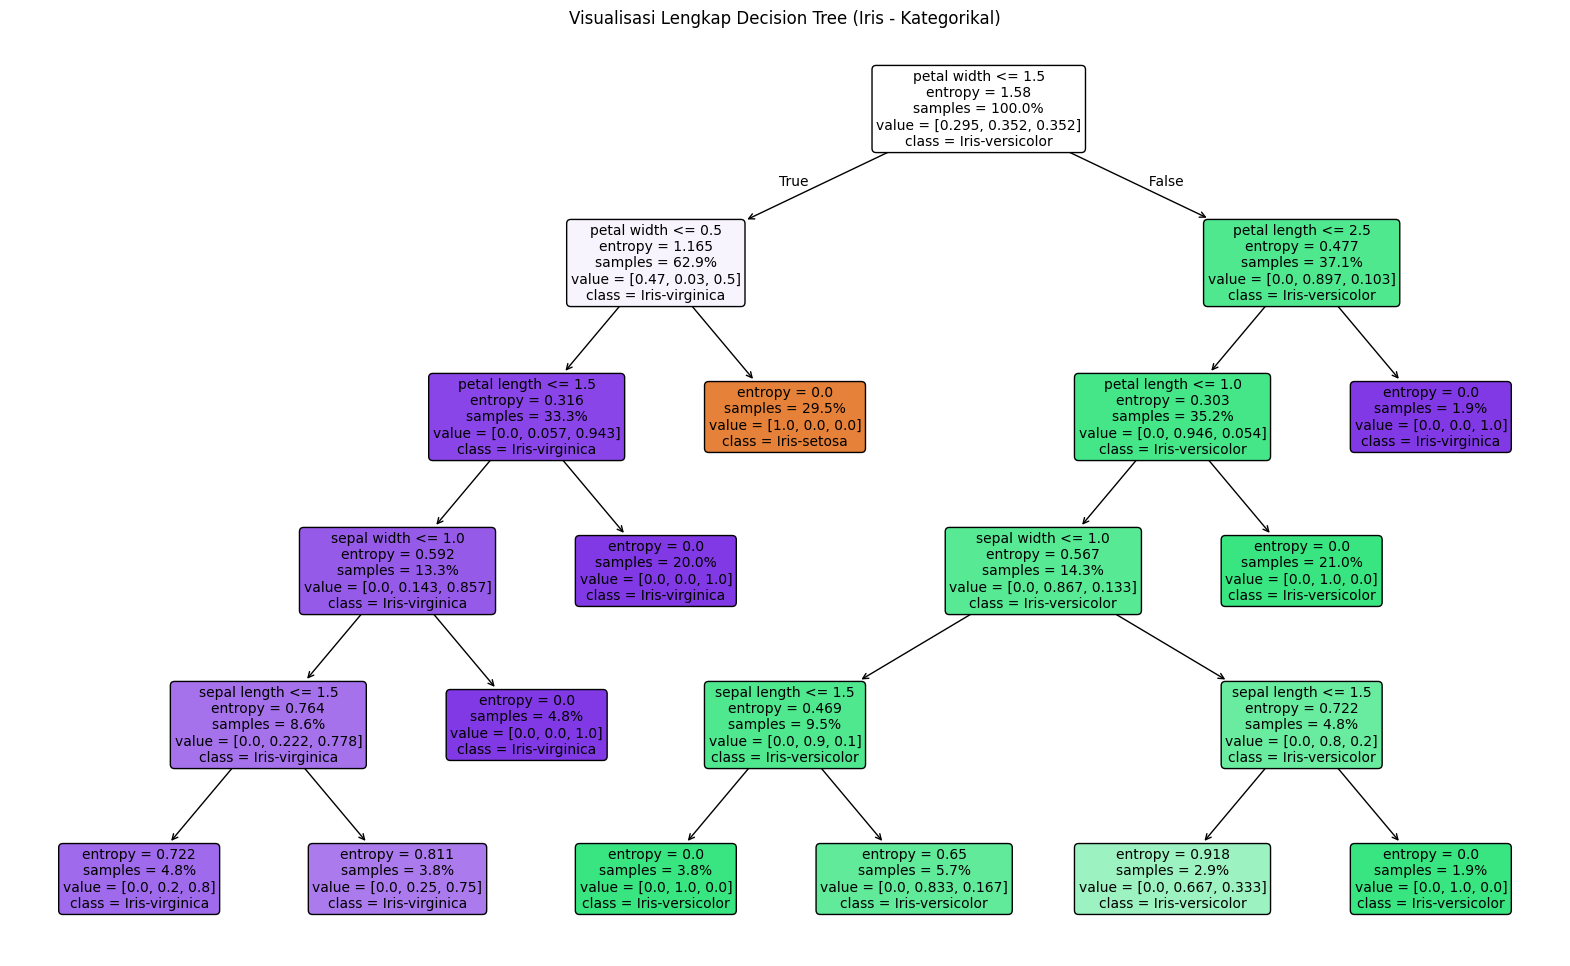

In [114]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 12))

plot_tree(
    model,
    feature_names=['sepal length', 'sepal width', 'petal length', 'petal width'],
    class_names=label_encoder.classes_,
    filled=True,
    rounded=True,
    impurity=True,         # Menampilkan impurity (Gini Index)
    proportion=True,       # Menampilkan proporsi sample
    fontsize=10
)

plt.title("Visualisasi Lengkap Decision Tree (Iris - Kategorikal)")
plt.show()


### Hitung Akurasinya

`accuracy_score(y_true, y_pred)` menghitung akurasi, yang didefinisikan sebagai:

$$
\text{Akurasi} = \frac{\text{Jumlah prediksi benar}}{\text{Jumlah total data uji}}
$$


In [115]:
from sklearn.metrics import accuracy_score

# Encode label asli ('Class') agar bisa dibandingkan dengan y_pred_all
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded_true = label_encoder.fit_transform(df_result['Class'])

# y_pred_all sudah berisi hasil prediksi (angka)
y_pred_all = df_result['Prediksi']

# Hitung akurasi
accuracy = accuracy_score(y_encoded_true, y_pred_all)

# Tampilkan hasil
print(f"\n=== Akurasi Klasifikasi pada Seluruh Data(dengan kolom Kategorical): {accuracy:.4f} atau {accuracy*100:.2f}%")



=== Akurasi Klasifikasi pada Seluruh Data(dengan kolom Kategorical): 0.9733 atau 97.33%


In [116]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Pastikan kolom numerik tanpa spasi
df.columns = df.columns.str.replace(' ', '_')
numeric_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df[numeric_cols] = df[numeric_cols].astype(float)

# Encode label jika belum dalam format numerik
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])

# Fitur dan target
X = df[numeric_cols]
y = df['Class']

# Leave-One-Out Evaluation untuk Decision Tree
model = DecisionTreeClassifier(criterion="entropy", random_state=42)
correct = 0

for i in range(len(df)):
    X_train = X.drop(index=i)
    y_train = y.drop(index=i)
    X_test = X.iloc[[i]]
    y_test = y.iloc[i]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if y_pred[0] == y_test:
        correct += 1

accuracy = correct / len(df)
print(f"🌳 Akurasi Decision Tree (Fitur numerik): {accuracy:.4f} atau {accuracy*100:.2f}%")


🌳 Akurasi Decision Tree (Fitur numerik): 0.9400 atau 94.00%


### Kesimpulan Perbandingan Akurasi pada klasifikasi data Iris dengan menggunakan Decision Tree antara data numerik dan kategorical

### 📊 Kesimpulan Perbandingan Akurasi Decision Tree pada Data Iris

Berikut adalah hasil perbandingan akurasi klasifikasi menggunakan algoritma **Decision Tree** pada data **Iris**, dengan dua jenis representasi fitur:

| Jenis Fitur     | Akurasi Decision Tree |
| --------------- | --------------------- |
| **Kategorikal** | **97.33%**            |
| **Numerik**     | **94.00%**            |

---

### ✅ Kesimpulan:

* Model **Decision Tree menghasilkan akurasi lebih tinggi saat menggunakan fitur kategorikal** (97.33%) dibandingkan dengan fitur numerik (94.00%).
* Ini menunjukkan bahwa **representasi kategorikal** dari fitur numerik (misalnya melalui proses discretization atau klasterisasi) dapat **membantu meningkatkan performa klasifikasi**, terutama ketika data memiliki batasan yang jelas antar kelas.
* Decision Tree memang cenderung cocok dengan data kategorikal karena struktur pohonnya bekerja berdasarkan pembelahan nilai yang diskrit.

